In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.patches as patches
from functools import partial
import gzip, pickle, copy
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch
%matplotlib inline

In [3]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [4]:
%%time
train_data = load_zipped_pickle("data/train.pkl")

CPU times: user 8.16 s, sys: 2.22 s, total: 10.4 s
Wall time: 10.9 s


In [5]:
idx_expert = []
idx_amateur = []
n_labeled = []
n_frames = []
frame_height = []
frame_width = []
dataset = []

for i, sample in enumerate(train_data):
    if sample['dataset'] == 'amateur':
        idx_amateur.append(i)
    else:
        idx_expert.append(i)
    
    n_labeled.append(len(sample['frames']))
    n_frames.append(sample['video'].shape[2])
    frame_width.append(sample['video'].shape[1])
    frame_height.append(sample['video'].shape[0])
    dataset.append(sample['dataset'])
    
    box = sample['box']
    
    
df_meta = pd.DataFrame({
    'n_labeled': n_labeled,
    'n_frames': n_frames,
    'frame_heigth': frame_height,
    'frame_width':frame_width,
    'dataset': dataset
})

In [6]:
class Window:
    def __init__(self, x0, y0, width, height):
        self.x = x0
        self.y = y0
        self.width = width
        self.height = height
        
    def crop(self, img):
        assert self.x + self.width < img.shape[0]
        assert self.y + self.height < img.shape[1]
        
        return img[
            self.y : self.y + self.height,
            self.x : self.x + self.width
        ]
    
    def to_mask(self):
        

In [7]:
def plot_window(w, ax):
    
    ax.add_patch(
         patches.Rectangle(
            (w.x, w.y),
            w.width,
            w.height,
            edgecolor = 'white',
            facecolor = 'red',
            fill=False
         )
    )
    return ax

<AxesSubplot:>

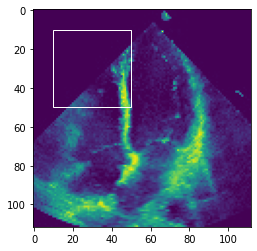

In [8]:
# Test plot window
w = Window(10, 10, 40, 40)
fig, ax = plt.subplots()
ax.imshow(train_data[0]['video'][..., 0])
plot_window(w, ax)

In [42]:
# generate windows
def generate_windows(img_dims=(112, 112), grid=5, w_dims=(30, 20)):
    w_width, w_height = w_dims
    img_width, img_height = img_dims

    windows = []
    
    # TODO: use heatmap as prior instead of offsets
    offset_x = img_width // 2 - grid * 3
    offset_y = 20

    for j in range(0, img_height - offset_y, grid):
        for i in range(offset_x, img_width, grid):
            if img_width < i + w_width:
                continue
            if img_height < j + w_height:
                continue

            windows.append(Window(i, j, w_width, w_height))
    return windows

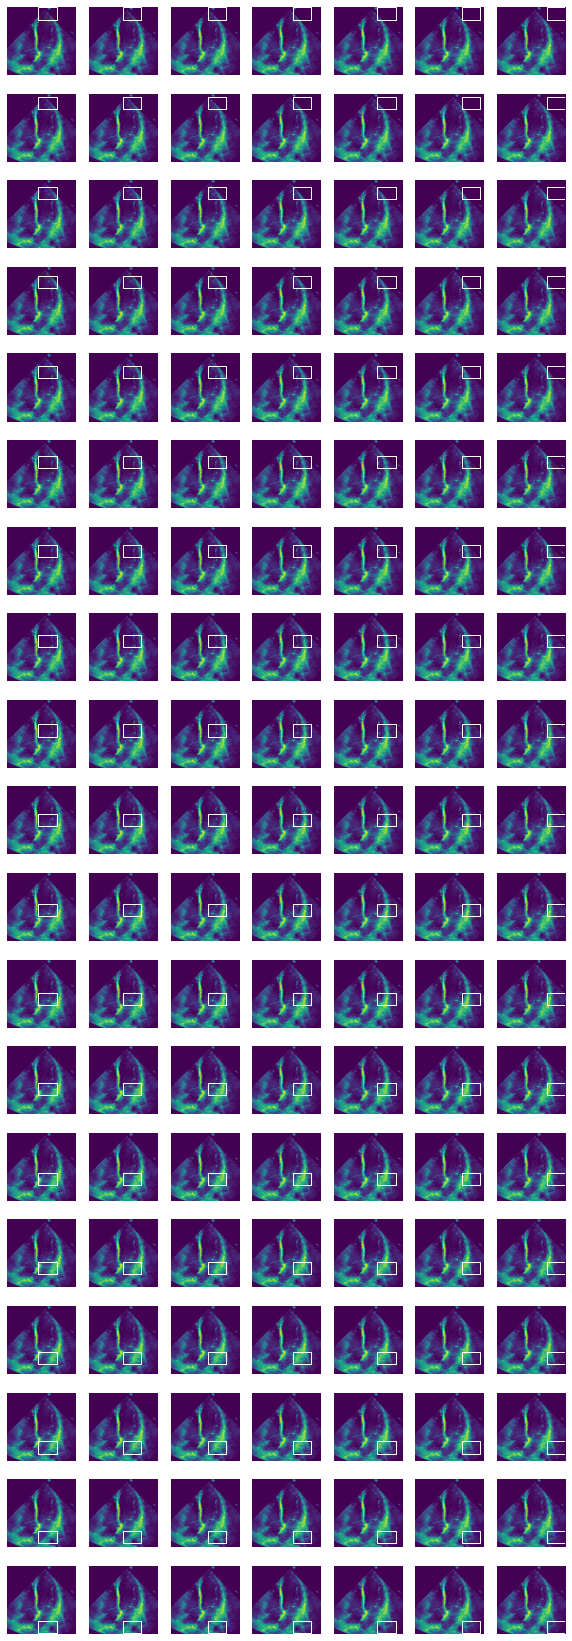

In [10]:
# Plot generated windows
windows = generate_windows()

ncols = 7
nrows = len(windows) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 30))
axes = axes.flatten()

sample_frame = train_data[0]['video'][..., 0]

windows = generate_windows()

for i, w in enumerate(windows):
    axes[i].imshow(sample_frame)
    plot_window(w, axes[i])
    axes[i].axis('off')

(600,)

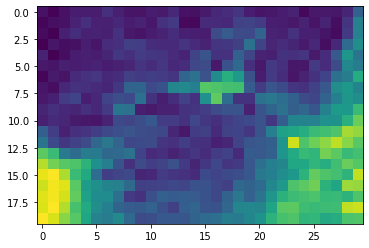

In [11]:
# Test cropping

cropped_frame = windows[84].crop(sample_frame)
plt.imshow(cropped_frame)
cropped_frame.flatten().shape

In [20]:


# According to Automatic Mitral Leaflet Tracking in Echocardiography
# by Outlier Detection in the Low-rank Representation
# Followint Algorithm 1

def spectral_analysis(video, windows, k=5):
    eps = []
    scaler = StandardScaler()
    scaler.fit(video[..., 0])

    for w in windows:
        M = []
        for i in range(video.shape[2]):
            frame = video[..., i]
            
            #frame = scaler.transform(frame)
            
            m = w.crop(frame).flatten()
            M.append(m)
        M = np.stack(M, axis=1)
        s = np.linalg.svd(M, compute_uv=False)
        e = np.sum(np.square(s[k:]))
        eps.append(e)
    l_star = np.argmax(np.array(eps))
    w_star = windows[l_star]
    return w_star

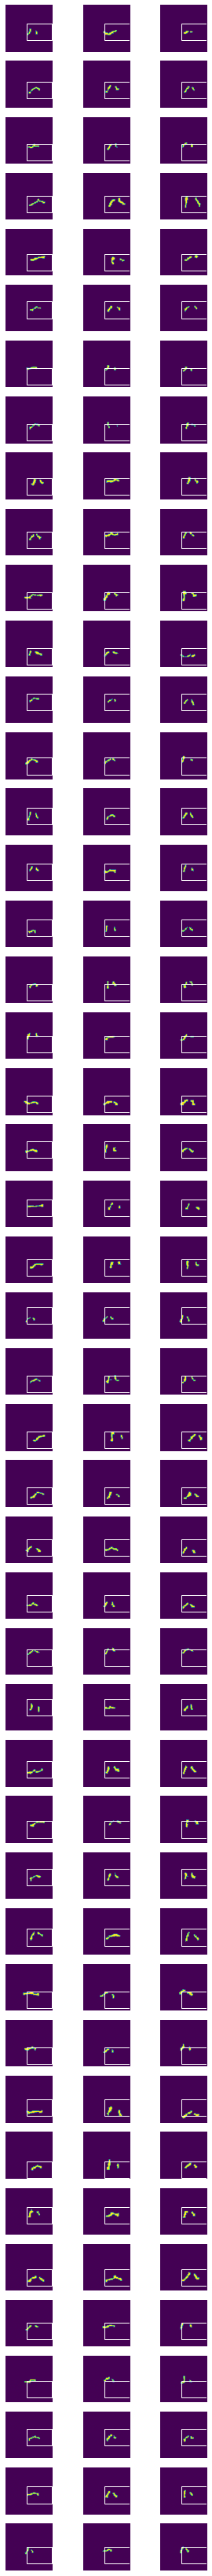

In [40]:
# Plot roi prediction on amateur

ncols = 3
nrows = len(idx_amateur)
fig, axes = plt.subplots(nrows, ncols, figsize=(5, 60))
axes = axes.flatten()

for i in tqdm(idx_amateur, leave=False):
    
    sample = copy.deepcopy(train_data[i])
    video = sample['video']
    frames = sample['frames']
    labels = sample['label']
    
    windows = generate_windows(w_dims=(60, 40))
    w_star = spectral_analysis(video, windows)
    
    for j, f in enumerate(frames):
        idx_plot = i* len(frames) + j
        #axes[idx_plot].imshow(video[..., f])
        axes[idx_plot].imshow(labels[..., f])
        plot_window(w_star, axes[idx_plot])
        axes[idx_plot].axis('off')

IndexError: index 57 is out of bounds for axis 0 with size 57

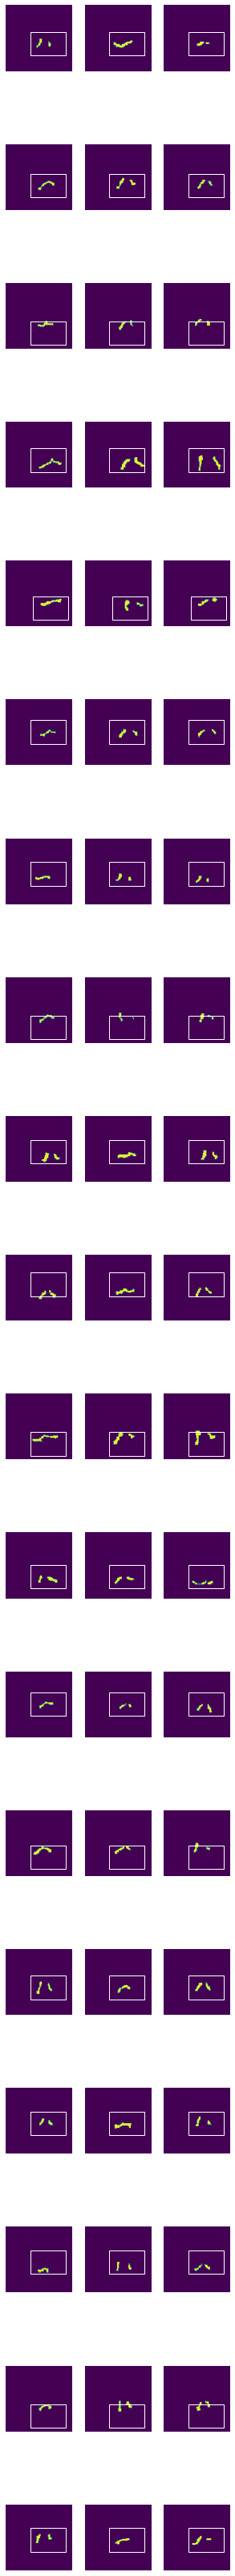

In [43]:
# Plot roi prediction on expert

ncols = 3
nrows = len(idx_expert)
fig, axes = plt.subplots(nrows, ncols, figsize=(5, 60))
axes = axes.flatten()

for i in tqdm(idx_amateur, leave=False):
    
    sample = copy.deepcopy(train_data[i])
    video = sample['video']
    frames = sample['frames']
    labels = sample['label']
    
    windows = generate_windows(w_dims=(60, 40))
    w_star = spectral_analysis(video, windows)
    
    for j, f in enumerate(frames):
        idx_plot = i* len(frames) + j
        #axes[idx_plot].imshow(video[..., f])
        axes[idx_plot].imshow(labels[..., f])
        plot_window(w_star, axes[idx_plot])
        axes[idx_plot].axis('off')

<AxesSubplot:>

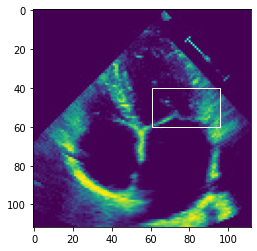

In [47]:
fig, ax = plt.subplots()
ax.imshow(video[..., 20])
plot_window(w_star, ax)

In [ ]:
eps, l_star, len(eps), len(windows)

In [ ]:

w_star.height